<a href="https://colab.research.google.com/github/smrtdylan/Dog-Identification-Network/blob/main/dogs_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
'''
this model is to understand the basics of how a ResNet architecture works. Modified code from PyTorch (https://pytorch.org/hub/pytorch_vision_resnet/).
Some occasional errors with this network as it was built for a lot of different animals and types of dogs as well.
'''

import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [9]:
from datasets import load_dataset

test = load_dataset("ajinkyakolhe112/dog_breed_classification_kaggle", split="train") # using train split because it actually has the label with what the expected output is supposed to be
test = test.shuffle(seed=42)



In [6]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2024-12-24 02:51:18--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2024-12-24 02:51:18 (106 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [7]:
from torchvision import transforms

def network(filename):


  preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(filename)
  input_batch = input_tensor.unsqueeze(0)


  torch.device('cuda')

  with torch.no_grad():
      output = model(input_batch)


  # get possibilities
  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  return probabilities


def getOutputs(probabilities, value):
  # Read the categories
  with open("imagenet_classes.txt", "r") as f:
      categories = [s.strip() for s in f.readlines()]
  # Show top categories per image
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  for i in range(top5_prob.size(0)):
      print(categories[top5_catid[i]] + ": " + str(top5_prob[i].item()*100) + "%")

  # print if the output is correct or not
  categories[top5_catid[0]] = categories[top5_catid[0]].lower() # converts label to lowercase, since the first letter in all labels in imagenet_classes.txt is uppercase.

  if (categories[top5_catid[0]] == (value)):
    print("CORRECT")
  else:
    print("INCORRECT | Answer is: " + value)



Image 1:


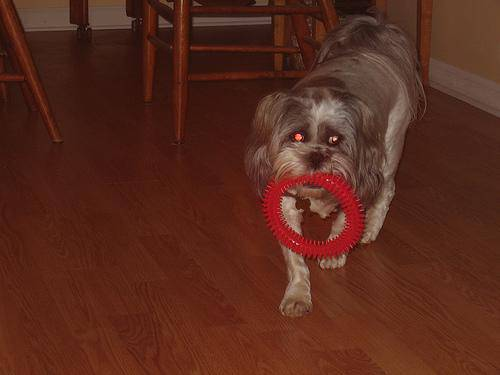

Lhasa: 88.04230093955994%
Shih-Tzu: 10.361069440841675%
Pekinese: 0.5963213741779327%
Tibetan terrier: 0.5739630665630102%
Maltese dog: 0.17081651603803039%
CORRECT



Image 2:


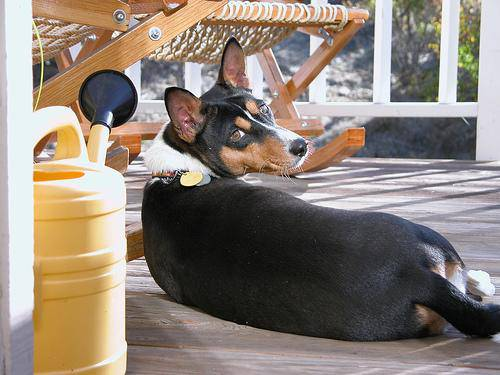

basenji: 48.37155044078827%
Cardigan: 12.340563535690308%
German shepherd: 7.009199261665344%
kelpie: 4.501328244805336%
Appenzeller: 3.4398067742586136%
CORRECT



Image 3:


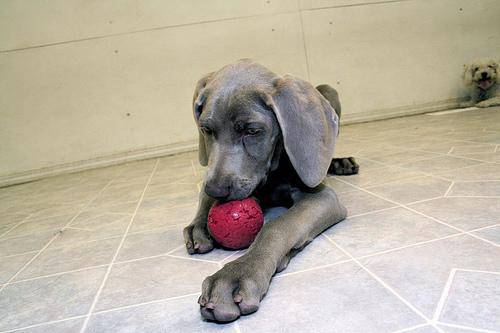

Weimaraner: 63.26408386230469%
Great Dane: 22.746722400188446%
Mexican hairless: 5.425998941063881%
Chesapeake Bay retriever: 2.302875928580761%
American Staffordshire terrier: 1.6781987622380257%
CORRECT



Image 4:


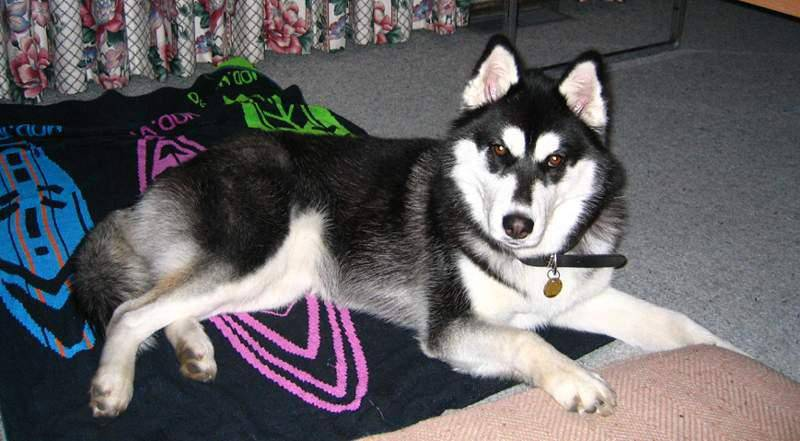

Siberian husky: 53.54427695274353%
Eskimo dog: 30.21719753742218%
malamute: 7.615246623754501%
Cardigan: 1.3159704394638538%
Pembroke: 1.2622573412954807%
CORRECT



Image 5:


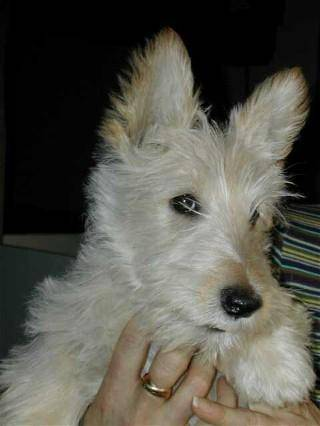

West Highland white terrier: 64.8930311203003%
cairn: 14.231322705745697%
Scotch terrier: 14.11619782447815%
Norwich terrier: 2.967727370560169%
wire-haired fox terrier: 1.4064482413232327%
INCORRECT | Answer is: scotch terrier



Image 6:


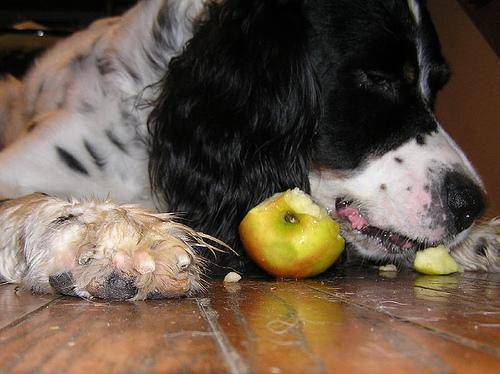

English setter: 21.362730860710144%
English springer: 16.043049097061157%
cocker spaniel: 11.482037603855133%
Bernese mountain dog: 8.58517810702324%
Blenheim spaniel: 5.436781421303749%
CORRECT



Image 7:


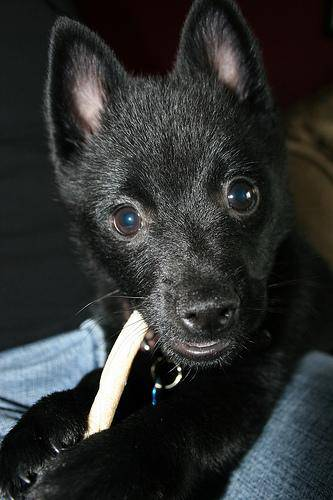

schipperke: 98.9155113697052%
groenendael: 0.5527947563678026%
Pomeranian: 0.16546322731301188%
kelpie: 0.07120958180166781%
Chihuahua: 0.0697531912010163%
CORRECT



Image 8:


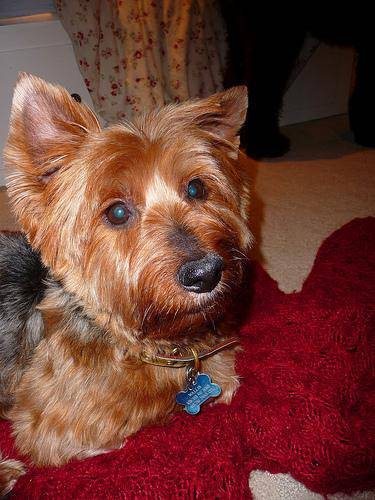

Australian terrier: 80.45521378517151%
silky terrier: 10.300201922655106%
Norwich terrier: 3.5153325647115707%
Yorkshire terrier: 1.9638266414403915%
Norfolk terrier: 1.4425587840378284%
CORRECT



Image 9:


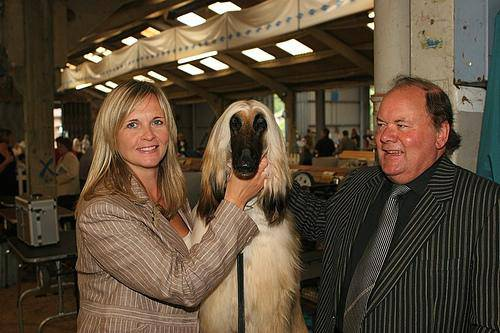

Afghan hound: 99.81687068939209%
Leonberg: 0.022600428201258183%
briard: 0.020880582451354712%
English setter: 0.019359157886356115%
llama: 0.015730946324765682%
CORRECT



Image 10:


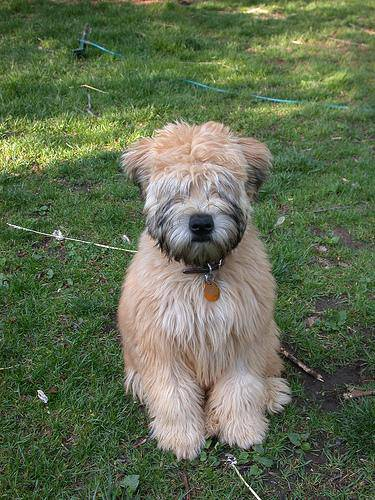

soft-coated wheaten terrier: 99.65121150016785%
Tibetan terrier: 0.1509654917754233%
Lhasa: 0.11286173248663545%
briard: 0.029814403387717903%
Irish terrier: 0.014134927187114954%
CORRECT





In [10]:
import time

labels = test.features["label"]._int2str

for x in range(10):
    print("Image " + str(x+1) + ":")
    filename = test[x]["image"]
    display(filename)

    value = test[x]["label"] # gets what type of dog the image actually is
    value = labels[value]
    value = value.replace("_", " ")

    probabilities = network(filename)
    getOutputs(probabilities, value)


    print("\n\n" )

    time.sleep(2.5)